# BioImage Model Zoo Example notebook

This notebook provides examples of how to load pretrained deep learning models from [BioImage Model Zoo](https://bioimage.io) and use them to process new images.

## **1. Install key dependencies**
---
<font size = 4>


### **1.0. Install required dependencies**

In [1]:
!pip install bioimageio.core==0.5.11
!pip install matplotlib==3.5.3
!pip install imageio==2.31.2
!pip install numpy==1.23.5
!pip install tensorflow==2.15

### **1.1. Load BioImageIO dependencies**

In [35]:
# BioImage Model Zoo
import os
from datetime import datetime

# If you'd rather read the warning messages, please comment the follwing two lines.
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from imageio import imread
import xarray as xr
import numpy as np
from bioimageio.core.resource_tests import test_model
from bioimageio.core import load_resource_description
from bioimageio.core import create_prediction_pipeline
from bioimageio.core.prediction import predict_image, predict_images
from bioimageio.core.resource_io.utils import resolve_source
from bioimageio.core.build_spec import build_model
import hashlib

import json
from pathlib import Path
import pooch
from ruamel.yaml import YAML
 
yaml = YAML(typ="safe")
 
COLLECTION_URL = "https://raw.githubusercontent.com/bioimage-io/collection-bioimage-io/gh-pages/collection.json"
 
collection_path = Path(pooch.retrieve(COLLECTION_URL, known_hash=None))
 
with collection_path.open() as f:

    collection = json.load(f)

model_urls = [entry["rdf_source"] for entry in collection["collection"] if entry["type"] == "model"]
 
model_rdfs = [yaml.load(Path(pooch.retrieve(mu, known_hash=None))) for mu in model_urls]
 
tensorflow_models = [rdf for rdf in model_rdfs if "tensorflow_saved_model_bundle" in rdf["weights"] or "keras_hdf5" in rdf["weights"]]

## **2. Inspect a model from the BioImage Model Zoo**

Here we will guide you through the basic functionalities of the BioImageIO Python packaget to interact with the content in the BioImage Model Zoo. General parameters to modify along the following cell.

In [ ]:
# nickname_list = []
print('List of models for TensorFlow:\n')

for model in tensorflow_models:
    # nickname_list.append(model['config']['bioimageio']['nickname'])
    print(f"{model['name']}\n - {model['config']['bioimageio']['nickname']}\n - {model['config']['bioimageio']['doi']}")

### **2.1. Load the resource description specifications of the model**

To load the resource there are different ways of doing it, you just need to provide **ONE** of the options bellow: 

<font size = 2>**`BMZ_MODEL_ID`**: Unique identifier of the model to load in the BioImage Model Zoo, e.g., `placid-llama`. These identifiers are given on each model card in the zoo.

OR

<font size = 2>**`BMZ_MODEL_DOI`**: Model DOIs can also be used to load the models.

OR

<font size = 2>**`BMZ_MODEL_URL`**: URL to the main Zenodo repository as well as to the `rdf.yaml` file containing the resource description specifications can be used to load models as well.

In [4]:
BMZ_MODEL_ID = "placid-llama" #@param {type:"string"}
BMZ_MODEL_DOI = "10.5281/zenodo.7261974"  #@param {type:"string"}
BMZ_MODEL_URL = "https://zenodo.org/records/7261974/files/rdf.yaml"  #@param {type:"string"}

# Load the model description
# ------------------------------------------------------------------------------

if BMZ_MODEL_ID != "":
    model = load_resource_description(BMZ_MODEL_ID)  # TODO: load from bioimageio id
    print(f"The model '{model.name}' with ID '{BMZ_MODEL_ID}' has been correctly loaded.")
elif BMZ_MODEL_DOI != "":
    model = load_resource_description(BMZ_MODEL_DOI)  # TODO: load from bioimageio id
    print(f"The model '{model.name}' with DOI '{BMZ_MODEL_DOI}' has been correctly loaded.")
elif BMZ_MODEL_URL != "":
    model = load_resource_description(BMZ_MODEL_URL)  # TODO: load from bioimageio id
    print(f"The model '{model.name}' with URL '{BMZ_MODEL_URL}' has been correctly loaded.")
else:
    print('Please specify a model ID, DOI or URL')

rdf.yaml: 4.53kiB [00:00, 5.05MiB/s]                  
training_evaluation.csv: 7.20kiB [00:00, 3.67MiB/s]
Contours2InstanceSegmentation.ijm: 100%|██████████| 2.32k/2.32k [00:00<00:00, 1.95MiB/s]
per_sample_scale_range.ijm: 100%|██████████| 4.36k/4.36k [00:00<00:00, 3.25MiB/s]
cover_1.png: 100%|██████████| 23.1k/23.1k [00:00<00:00, 212kiB/s]
cover.png: 100%|██████████| 66.6k/66.6k [00:00<00:00, 306kiB/s]
README.md: 100%|██████████| 205/205 [00:00<00:00, 209kiB/s]
sample_input_0.tif: 100%|██████████| 262k/262k [00:00<00:00, 605kiB/s]
sample_output_0.tif: 100%|██████████| 3.15M/3.15M [00:00<00:00, 3.57MiB/s]
test_input.npy: 100%|██████████| 262k/262k [00:00<00:00, 606kiB/s]
test_output.npy: 100%|██████████| 3.15M/3.15M [00:00<00:00, 3.59MiB/s]
keras_weights.hdf5: 100%|██████████| 30.9M/30.9M [00:02<00:00, 13.5MiB/s]
tf_weights.zip: 100%|██████████| 31.3M/31.3M [00:02<00:00, 14.3MiB/s]

The model 'B. Sutilist bacteria segmentation - Widefield microscopy - 2D UNet' with ID 'placid-llama' has been correctly loaded.


### **2.2. Discover the different components and features of the model**

The model 'B. Sutilist bacteria segmentation - Widefield microscopy - 2D UNet' had the following properties and metadata

 Description This trained 2D U-Net model segments the contour, foreground and background of Bacillus Subtilis bacteria imaged with Widefield microscopy images. To obtain a unique label for each individual bacteria detected in the image one could run further watershed segmentation using the label 1 as the seed.

 The authors of the model are [Author(name='Estibaliz Gómez de Mariscal', affiliation='Instituto Gulbenkian de Ciência', email=<marshmallow.missing>, github_user=<marshmallow.missing>, orcid=<marshmallow.missing>)]
 and it is maintained by: [Maintainer(name='Estibaliz Gómez de Mariscal', affiliation=<marshmallow.missing>, email=<marshmallow.missing>, github_user='esgomezm', orcid=<marshmallow.missing>)]
 License: MIT

 If you use this model, you are expected to cite [CiteEntry(text='Falk et al. Nature Methods 2019', doi='10.1038/s41592-018-0261-2', url='https

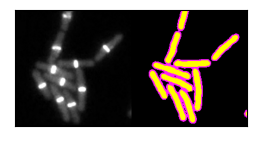

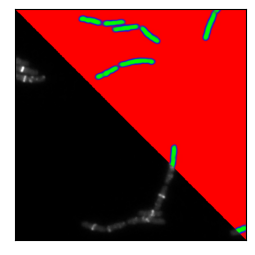

In [7]:
print(f"The model '{model.name}' had the following properties and metadata")
print()
print(f" Description {model.description}")
print()
print(f" The authors of the model are {model.authors}")
print(f" and it is maintained by: {model.maintainers}")
print(f" License: {model.license}")
print()

print(f" If you use this model, you are expected to cite {model.cite}")
print()
print(f" Further documentation can be found here: {model.cite}")
print()
print(f" GitHub repository: {model.git_repo}")
print()
print(f"Covers of the model '{model.name}'")
for cover in model.covers:
    cover_data = imread(cover)
    plt.figure(figsize=(3,3))
    plt.imshow(cover_data)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [8]:
print("Available weight formats for this model:", model.weights.keys())
print("Pytorch state dict weights are locally stored at:", model.weights)
print()

# or what inputs the model expects
print(f"The model requires {len(model.inputs)} input(s) with the following features:")
for inp in model.inputs:
    print("Input with axes:", inp.axes, "and shape", inp.shape)
    print(f"It is expected to be processed with: {inp.preprocessing}")
print()
# and what the model outputs are
print(f"The model requires {len(model.outputs)} output(s) with the following features:")
for out in model.outputs:
    print("Output with axes:", out.axes, "and shape", out.shape)
    print(f"The output image has a halo of : {out.halo}")
    print(f"It is expected to be postprocessed with: {out.postprocessing}")

Available weight formats for this model: dict_keys(['keras_hdf5', 'tensorflow_saved_model_bundle'])
Pytorch state dict weights are locally stored at: {'keras_hdf5': KerasHdf5WeightsEntry(authors=<marshmallow.missing>, attachments=<marshmallow.missing>, parent=<marshmallow.missing>, sha256='3b351ad5af1dab75c16993f9da06ce15d84b38435b2ce6f6a799c7d5fde3b80d', source=PosixPath('/tmp/root/bioimageio_cache/https/zenodo.org/api/records/7782776/files/keras_weights.hdf5'), tensorflow_version=<Version('2.11.0')>, dependencies=<marshmallow.missing>), 'tensorflow_saved_model_bundle': TensorflowSavedModelBundleWeightsEntry(authors=<marshmallow.missing>, attachments=<marshmallow.missing>, parent=<marshmallow.missing>, sha256='4780c1df39c35db679237acedc964dc58032474495042539a16941e8cb333d17', source=PosixPath('/tmp/root/bioimageio_cache/https/zenodo.org/api/records/7782776/files/tf_weights.zip'), tensorflow_version=<Version('2.11.0')>, dependencies=<marshmallow.missing>)}

The model requires 1 input(s

The model provides 1 test input image(s) :


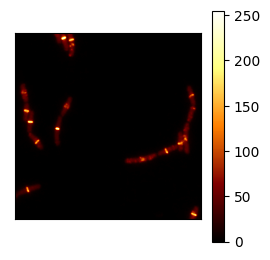

The model provides 1 test input image(s) :
The shape of the test input is (512, 512, 3), so it will not displayed


In [17]:
# Inspect the test input images
print(f"The model provides {len(model.test_inputs)} test input image(s) :")
for test_im in model.test_inputs:
    test_input = np.squeeze(np.load(test_im))
    if len(test_input.shape)>2:
        try:
            print(f"The axes of the test input image are {test_input.axes} and its shape {test_input.shape}, so it will not displayed")
        except:
            print(f"The shape of the test input is {test_input.shape}, so it will not displayed")
    else:
        plt.figure(figsize=(3,3))
        plt.imshow(test_input, cmap="afmhot")
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.show()


# Inspect the test output images
print(f"The model provides {len(model.test_outputs)} test input image(s) :")
for test_im in model.test_outputs:
    test_output = np.squeeze(np.load(test_im))
    if len(test_output.shape)>2:
        try:
            print(f"The axes of the test input image are: {test_output.axes} and its shape {test_output.shape}, so it will not displayed")
        except:
            print(f"The shape of the test input is {test_output.shape}, so it will not displayed")
    else:
        plt.figure(figsize=(3,3))
        plt.imshow(test_output, cmap="afmhot")
        plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        plt.show()


## 3. Test the model

Both the model format and the deployment of the model can be tested. First we can run a static validation to check that the model follows the format of the BioImage Model Zoo correctly.

Then, we can check that it actually produces the output that is expected to produce, which is called dynamic validation. The latter is done by running a prediction for the test input images and checking that they agree with the test output(s). The running time this time will depend on the resources available (e.g., GPU acceleration).

In [18]:
# 'test_model' returns a dict with 'status'='passed'/'failed' and more detailed information

for test_result in test_model(model):
    if test_result["status"] == "failed":
        print("model test:", test_result["name"])
        print("The model test failed with:", test_result["error"])
        print("with the traceback:")
        print("".join(test_result["traceback"]))
    else:
        print("model test:", test_result["name"])
        test_result["status"] == "passed"
        print("The model passed the test.")
        print()
print(f"The modle was tested using:")
print(f"'bioimageio_spec_version': '{test_result['bioimageio_spec_version']}'")
print(f"'bioimageio_core_version': '{test_result['bioimageio_core_version']}'")

computing dataset statistics: 0it [00:00, ?it/s]


1/1 [==============================] - 8s 8s/step
model test: load resource description
The model passed the test.

model test: has expected resource type
The model passed the test.

model test: All URLs and paths available
The model passed the test.

model test: Test documentation completeness.
The model passed the test.

model test: reproduce test outputs from test inputs (bioimageio.core 0.5.11)
The model passed the test.

The modle was tested using:
'bioimageio_spec_version': '0.4.9post5'
'bioimageio_core_version': '0.5.11'


## 4. Use the model with new images

The BioImageIO library includes functions to run prediction with `xarray.DataArrays` or on images stored on disc.

### **4.1. Process an input array**

The prediction pipeline expects inputs as `xarray.DataArrays`, which are similar to `numpy` arrays, but allow for named dimensions (the dims keyword argument).
In bioimage.io the dims have to agree with the input axes required by the model

computing dataset statistics: 0it [00:00, ?it/s]


1/1 [==============================] - 6s 6s/step


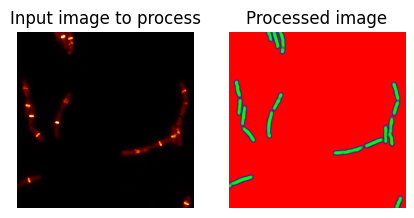

In [22]:
# load the example image for this model, which is stored in numpy file format
input_image = np.load(model.test_inputs[0])

# "devices" can be used to run prediction on a gpu instead of the cpu
devices = None
# "weight_format" to specify which weight format to use in case the model contains different weight formats
weight_format = None
# the prediction pipeline combines preprocessing, prediction and postprocessing.
# it should always be used for prediction with a bioimageio model
pred_pipeline = create_prediction_pipeline(
    bioimageio_model=model, devices=devices, weight_format=weight_format
)
# the prediction pipeline expects inputs as xarray.DataArrays.
axes = tuple(model.inputs[0].axes)
input_tensor = xr.DataArray(input_image, dims=axes)

# the prediction pipeline call expects the same number of inputs as the number of inputs required by the model
# in the case here, the model just expects a single input. in the case of multiple inputs use
# prediction = pred_pipeline(input1, input2, ...)
# or, if you have the inputs in a list or tuple
# prediction = pred_pipeline(*inputs)
# the call returns a list of output tensors, corresponding to the output tensors of the model
# (in this case, we just have a single output)
prediction = pred_pipeline(input_tensor)

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(input_image), cmap="afmhot")
plt.axis('off')
plt.title("Input image to process")
plt.subplot(1,2,2)
plt.imshow(np.squeeze(prediction), cmap="afmhot")
plt.axis('off')
plt.title("Processed image")
plt.show()


### **4.2 Process an image from a directory and save the result**

The BioImageIO is equipped with the utility function `predict_image` to run prediction with an image stored on disc. The filepath where the output should be stored (`save_outputs`), supports most common image formats as well as `npy` fileformat.

computing dataset statistics: 0it [00:00, ?it/s]


1/1 [==============================] - 6s 6s/step


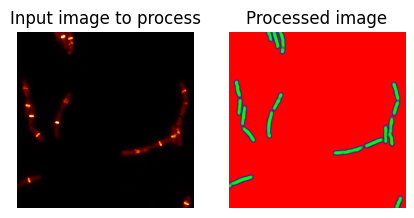

In [23]:
# path + name of the stored output
save_outputs = "/home/prediction.tif"  # @param {type:"string"}
save_outputs = [save_outputs]
path2image = model.test_inputs

# model resource, the image that will be process, path to store the output
predict_image(model, path2image, save_outputs)

# the output tensor contains 2 channels, which is not supported by normal tif.
# thus, these 2 channels are stored as 2 separate images

fg_pred = imread(save_outputs[0])
input_image = np.load(model.test_inputs[0])

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(input_image), cmap="afmhot")
plt.axis('off')
plt.title("Input image to process")
plt.subplot(1,2,2)
plt.imshow(fg_pred, cmap="afmhot")
plt.axis('off')
plt.title("Processed image")
plt.show()


### **4.3 Process a set of images stored in a directory**
It is possible to provide a list of images to analyse and run the analysis automatically. In this analysis `padding` and `tiling` strategies are enabled.

In [48]:
# Indicate a directory with images to analyse and a directory to save the images
im_dir = "" # @param {type:"string"}
results_dir = "" # @param {type:"string"}
os.makedirs(results_dir, exist_ok=True)

# Get the list of images to analyse and the same list to save the images
inputs = [os.path.join(im_dir,f) for f in os.listdir(im_dir) if not f.startswith('.')]
outputs = [os.path.join(results_dir, os.path.split(inp)[1]) for inp in inputs]

print(len(inputs), "images for prediction were found")

predict_images(model, inputs, outputs, verbose=False)


10 images for prediction were found


computing dataset statistics: 0it [00:00, ?it/s]


1/1 [==============================] - 8s 8s/step


In [50]:
# If the images are too big we can even choose a padding.
padding = {"x": 16, "y": 16, "mode": "dynamic"}
predict_images(model, inputs, outputs, padding=padding, verbose=False)

computing dataset statistics: 0it [00:00, ?it/s]


1/1 [==============================] - 7s 7s/step


In [54]:
# instead of padding, we can also use tiling.
# here, we specify a tile size of 512 and a halo (= extension of tile on both sides)
# size of 16, which results in an effective tile shale of 544 = 512 + 2*16
tiling = {
    "tile": {"x": 512, "y": 512},
    "halo": {"x": 16, "y": 16},
}

predict_images(model, inputs, outputs, tiling=tiling, verbose=False)

computing dataset statistics: 0it [00:00, ?it/s]


1/1 [==============================] - 6s 6s/step


## 5. Create a BioImage Model Zoo model

Let's recreate a model based on parts of the loaded model description from above!

`bioimageio.core` also implements functionality to create a model package compatible with the [BioImnageIO Model Spec](https://bioimage.io/docs/#/bioimageio_model_spec) ready to be shared via the [Bioimage Model Zoo](https://bioimage.io/#/).
Here, we will use this functionality to create two models, one that adds thresholding as post-processing to the outputs and another one that also adds weights in torchscript format.

For this we are using thre previous model including some changes as new postprocessing pipelines.

In [ ]:
## TODO
# ------
